In [2]:
import os
import datetime
import copy
import torch
import tqdm
import numpy as np 
import gymnasium as gym
from gym.utils.env_checker import check_env
from typing import (
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import stable_baselines3

2023-05-11 01:44:28.642710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 01:44:29.446677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

In [3]:
N = 100 # number of datapoints 
x = np.linspace(-2, 2, N) # sequences from -3 to 3 with N values

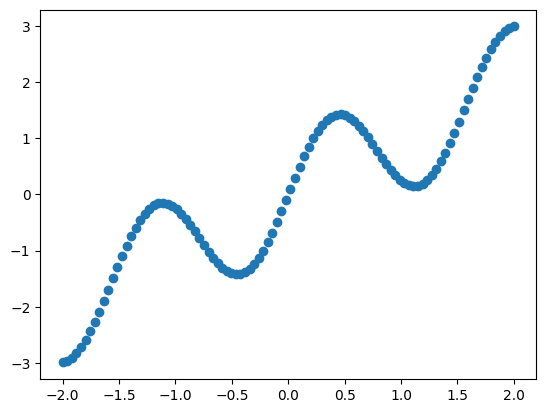

In [4]:
sine_wave = x + np.sin(4*x)
plt.plot(x, sine_wave, 'o');

In [5]:
# y
sine_wave

array([-2.98935825, -2.95947432, -2.90353058, -2.82193204, -2.71575235,
       -2.58670583, -2.43710276, -2.26978919, -2.08807276, -1.89563649,
       -1.69644281, -1.49463023, -1.29440554, -1.09993415, -0.91523152,
       -0.74405849, -0.58982329, -0.4554927 , -0.34351473, -0.25575481,
       -0.19344717, -0.15716269, -0.14679399, -0.16155828, -0.20001769,
       -0.2601168 , -0.33923622, -0.4342608 , -0.54166086, -0.6575842 ,
       -0.77795645, -0.89858731, -1.01527972, -1.12393929, -1.22068097,
       -1.30193034, -1.36451675, -1.40575595, -1.42352009, -1.41629312,
       -1.38321035, -1.32408098, -1.23939303, -1.13030068, -0.99859414,
       -0.84665305, -0.67738437, -0.49414671, -0.30066274, -0.10092218,
        0.10092218,  0.30066274,  0.49414671,  0.67738437,  0.84665305,
        0.99859414,  1.13030068,  1.23939303,  1.32408098,  1.38321035,
        1.41629312,  1.42352009,  1.40575595,  1.36451675,  1.30193034,
        1.22068097,  1.12393929,  1.01527972,  0.89858731,  0.77

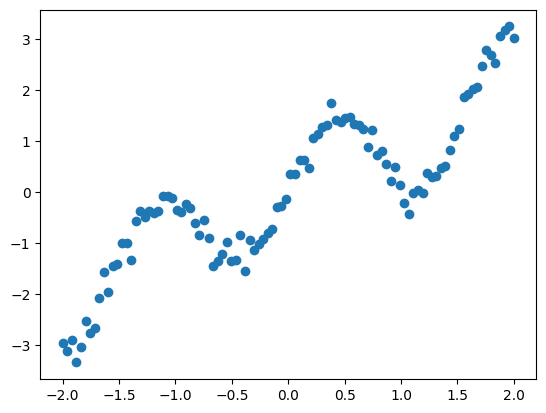

In [6]:
noisy_sine_wave = x + np.sin(4*x) + np.random.normal(0,0.2, 100)
plt.plot(x, noisy_sine_wave, 'o');

In [7]:
# neural network regression
# this has the same architecture for every hidden layer by design
model = torch.nn.Sequential(
    torch.nn.Linear(1, 24),
    torch.nn.ReLU(),
    torch.nn.Linear(24, 24), # hidden layer 1
    torch.nn.ReLU(),
    torch.nn.Linear(24, 24), # hidden layer 2
    torch.nn.ReLU(),
    torch.nn.Linear(24, 1)
)
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(1, 24),
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 1
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 2
        torch.nn.ReLU(),
        torch.nn.Linear(24, 1)
    )

def save_model(model: torch.nn.Module,path: str) -> None:
    torch.save(model.state_dict(), path)

def load_model(model: torch.nn.Module, path: str) -> torch.nn.Module:
    model.load_state_dict(torch.load(path))    
    
def split_data(X: np.ndarray,
               y: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # wraps sklearn's train_test_split
    # added functionality is converting to torch tensor type and reshaping
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

def train_regression_model(model: torch.nn.Module,
                           opt: torch.optim,
                           loss_fn: torch.nn.modules.loss,
                           X_train: torch.Tensor, 
                           y_train: torch.Tensor, 
                           X_test: torch.Tensor, 
                           y_test: torch.Tensor, 
                           save_path: str,
                           n_epochs: int=500, 
                           batch_size: int=1,
                           show_progress: bool=True) -> Tuple[List[torch.Tensor], 
                                                              List[torch.Tensor], 
                                                              float, 
                                                              OrderedDict[str, torch.tensor]]:
    best_mse = np.inf
    best_weights = None
    loss_history = []
    prediction_history = []
    
    ##############
    # 500 epochs 
    ##############
    for epoch in range(n_epochs):
        # train model on batches (which here is just a singular value)
        model.train()
        ################
        # 100 samples 
        ################
        if show_progress:
            pbar = tqdm.tqdm(total=len(X_train))
            pbar.set_description(f"Epoch {epoch}")
        for batch_index in range(round(len(X_train)/batch_size)):
            ################
            # 1 sample at a time (batch size = 1)
            ################
            X_batch = X_train[batch_index : batch_index + batch_size]
            y_batch = y_train[batch_index : batch_index + batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # update weights via backprop
            opt.zero_grad()
            loss.backward()
            opt.step()

            if show_progress: pbar.update(10)
        if show_progress: pbar.close()

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        loss_history.append(mse)
        prediction_history.append(y_pred)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
            torch.save({'epoch': epoch+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': opt.state_dict(),
                        }, save_path)        
    
    return prediction_history, loss_history, best_mse, best_weights


In [9]:
# depiction of how batch training works (i.e., that you just returned a 
# vector with as the same # of outputs and you passed inputs)
print(X_train[0:5])
print(model(X_train[0:5]))
print()
print(X_train[0])
print(model(X_train[0]))

NameError: name 'X_train' is not defined

# Global training params

In [10]:
NUM_LAYERS=100
NUM_NODES=128
SEED=12
LOSS_FN=torch.nn.MSELoss()
EPOCHS=1000
PATH=os.path.join(os.path.abspath(""), f"model-{datetime.datetime.now()}.pth")
MODEL=build_model()
OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)
LOSS_FN = torch.nn.MSELoss()

def reset_env():
    DEFAULT_NUM_LAYERS=100
    DEFAULT_NUM_NODES=128
    DEFAULT_SEED=12
    DEFAULT_LOSS_FN=torch.nn.MSELoss()
    EPOCHS=1000
    PATH=os.path.join(os.path.abspath(""), f"model-{datetime.datetime.now()}.pth")
    MODEL=build_model()
    OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)
    LOSS_FN = torch.nn.MSELoss()
    print(PATH)


# Train (normal data)

In [257]:
%%time
prediction_history, loss_history, best_mse, best_weights = train_regression_model(MODEL, 
                                                                                  OPT,
                                                                                  LOSS_FN,
                                                                                  X_train, 
                                                                                  y_train, 
                                                                                  X_test, 
                                                                                  y_test, 
                                                                                  save_path=PATH,
                                                                                  n_epochs=500, 
                                                                                  batch_size=1, 
                                                                                  show_progress=False)

CPU times: user 41.5 s, sys: 78 ms, total: 41.6 s
Wall time: 20.8 s


In [258]:
# list of length n with tensor([30,1]), where n is the number of epochs we ran
print(type(prediction_history))
print(len(prediction_history))
prediction_history[0].shape

<class 'list'>
500


torch.Size([30, 1])

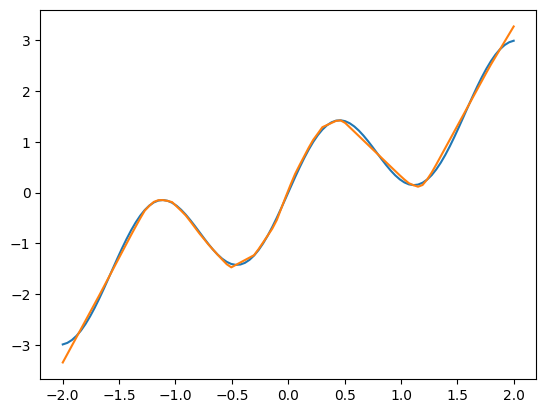

In [259]:
# print predicted values for each of the 100 x values between -2 and 2
# converting to tensor to run it through the model
# then converting it to numpy to plot it 
predictions = [model(torch.tensor(sample).float()) for sample in x.reshape((N,1))]
plt.plot(x, x + np.sin(4*x))
plt.plot(x, np.array([_.detach().numpy() for _ in predictions]));

In [269]:
# functions for to create above performance curve
def make_predictions(X: torch.Tensor, 
                     model: torch.nn.Module) -> List[torch.Tensor]:
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, 
                                   y: torch.Tensor, 
                                   y_hat: torch.Tensor,
                                   plot_title: str="line fit") -> None:
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions() and
    #   has form 
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)

MSE: 0.00
RMSE: 0.05


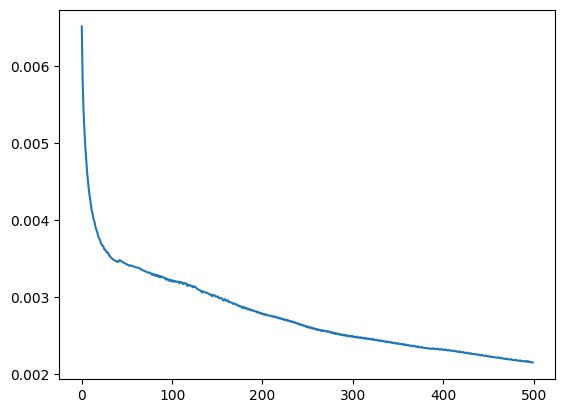

In [270]:
# visualize the mean squared error (mse)
# non-noisy sine wave
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(loss_history)
plt.show()

# Train (noisy data)

In [262]:
x_for_split = x.reshape((N,1))
X_train, y_train, X_test, y_test = split_data(x_for_split, sine_wave)
noisy_X_train, noisy_y_train, noisy_X_test, noisy_y_test = split_data(x_for_split, noisy_sine_wave)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


torch.Size([70, 1])
torch.Size([70, 1])
torch.Size([30, 1])
torch.Size([30, 1])


In [263]:
reset_env()

/home/matt/Documents/masters-thesis/src/model-2023-05-10 16:40:51.790257.pth


In [264]:
%%time
nprediction_history, nloss_history, nbest_mse, nbest_weights = train_regression_model(MODEL, 
                                                                                      OPT,
                                                                                      LOSS_FN,
                                                                                      noisy_X_train, 
                                                                                      noisy_y_train, 
                                                                                      noisy_X_test, 
                                                                                      noisy_y_test, 
                                                                                      save_path=PATH,
                                                                                      n_epochs=500, 
                                                                                      batch_size=1, 
                                                                                      show_progress=False)

CPU times: user 41 s, sys: 26.9 ms, total: 41 s
Wall time: 20.2 s


MSE: 0.03
RMSE: 0.17


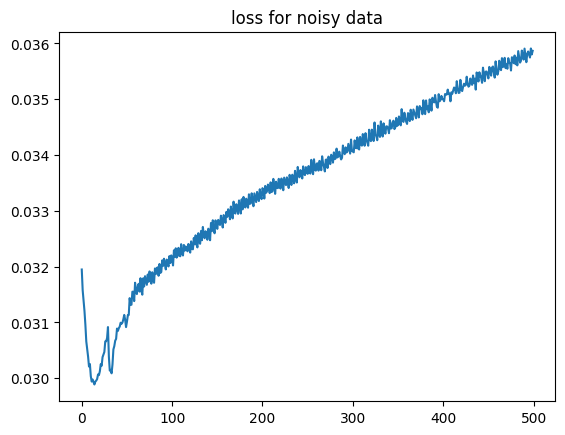

In [271]:
# noisy sine wave
print("MSE: %.2f" % nbest_mse)
print("RMSE: %.2f" % np.sqrt(nbest_mse))
plt.title("loss for noisy data")
plt.plot(nloss_history)
plt.show()

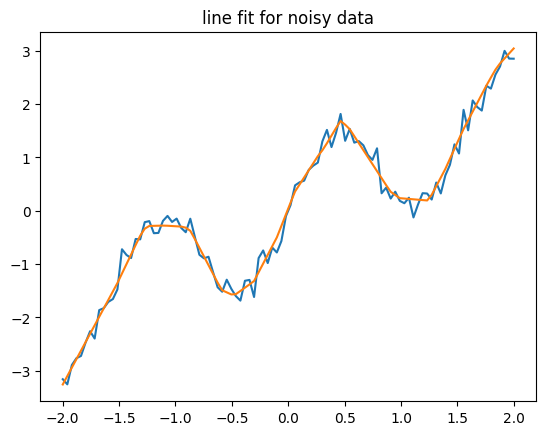

In [273]:
predictions = make_predictions(x, MODEL)
plot_predictions_versus_ground(x, noisy_sine_wave, predictions, plot_title="line fit for noisy data")

# Reinforcement Meta-Learning

3 classes
- layer pool
- target network -- composed of layers from layer pool
- meta learner -- decides which layers from layer pool to add to target network

So, (meta learner) -> (layer pool) -> (target network)

In [249]:
# Create custom env, where each env is where a 'target' model
#   is built for a task. 
# Create agent, where the agent is the meta-learning policy
#   selecting which next layer if any to compose with existing
#   layers.

In [232]:
class LayerPool:
    def __init__(self, 
                 num_layers: int=DEFAULT_NUM_LAYERS, 
                 num_nodes_per_layer: int=DEFAULT_NUM_NODES) -> List[np.ndarray]:
        self.num_layers = num_layers
        self.num_nodes_per_layer = num_nodes_per_layer
        # pre-initialize all layers in dict as 'layer_id' : layer, with xavier uniform
        self.layers = { 
                       f"layer_id_{0}".format(i) : torch.nn.Linear(in_features=num_nodes_per_layer,
                                                                   out_features=num_nodes_per_layer) 
                       for i in num_layers
        }
        [torch.nn.init.xavier_uniform(layer.weight) for _, layer in self.layers.items()]
    
    def update_layer(self, 
                     layer_id: str, 
                     layer: torch.nn.Linear) -> None:
        # called by agent after gradient update is made to layer
        self.layers[layer_id] = layer

    def get_layer(self) -> torch.nn.Linear:
        # called by target model to get the next layer for architecture
        # current design is to choose next layer randomly
        return self.layers[np.random.choice(self.num_layers, 1)]

In [245]:
class TargetNetwork(gym.Env):
    '''
    Contains the states and the rewards for those states. In this context,
    this is where the 'target' model for the task is constructed. If mode is
    set to 'train' then some preset # of layers is used to 
    
    step() returns the next state (the next layer) and reward (the negative loss)
    reset() returns an initial state and the info dict
    '''
    def __init__(self, 
                 X: np.ndarray,
                 y: np.ndarray,
                 layer_pool: LayerPool,
                 num_layers: int=NUM_LAYERS,
                 num_nodes_per_layer: int=NUM_NODES,
                 loss_fn: Callable=LOSS_FN,
                 opt: torch.optim=OPT):
        super(TargetNetwork, self).__init__()

        # gym-required
        self.observation_space = gym.spaces.Box(low=float('inf'), high=float('-inf'), shape=(num_nodes_per_layer,))
        self.action_space = gym.spaces.Box(low=0., high=1., shape=(num_layers+1,)) # +1 for the 'no layer' option

        # network 
        self.loss_fn = loss_fn
        self.opt_fn = opt
        self.layer_pool = layer_pool
        self.state = self.reset() # should this include the loss of the model too?
        self.parameters = None

    def reset(self, seed=SEED) -> Tuple:
        # Returns initial state (as the same type 'obsevation_space' is) and any 
        # additional info (as a dict, the same as returned by step).
        super().reset(seed=seed)
        _initial_x = np.random.choice(x.detach().numpy(), 1)
        random_nn_layer = self.layer_pool[np.random.choice(self.num_layers, 1)] # index to grab random layer from pool
        self.model.parameters() = random_nn_layer
        initial_state = torch.nn.ReLU(random_nn_layer(_initial_x))
        return initial_state, {}
    
    def forward(self, x):
        # TODO(ms): update parameters of some base model
        pred = model(x)
        return pred

    def step(self, action):
        state_prime = self.forward(action)
        # reward = ...method(state_prime)
        done = truncated = False
        y = ...
        y_hat = self.forward(x)
        reward = self.loss_fn(y, y_hat)
        return (
            state_prime,
            reward, 
            done, 
            truncated, 
            {}
        )

    def close(self):
        pass

In [252]:
class Task:
    # holds the datasets, such as our sine_wave and noisy_sine_wave examples
    # tasks can either be ones we train on or those we generalize for
    pass

In [253]:
class ReinforcementMetaLearning:
    def __init__(self, 
                 env: gym.Env, 
                 tasks: Task, 
                 device: str='cpu'):
        self.targets = [Target(task.X, task.y) for task in tasks]
        self.layers = LayerPool()
        self.model = stable_baselines3.A2C("MlpPolicy", env=env, device=device) # this expects 1 environment though....
